# Sleep staging on the Sleep Physionet dataset

In this tutorial, we will learn how to train a convolutional neural network on raw EEG data to classify sleep stages.

This tutorial is based on the [MNE-Python](https://mne.tools/stable/auto_tutorials/sample-datasets/plot_sleep.html) and [braindecode](https://braindecode.org/auto_examples/plot_sleep_staging.html) sleep staging examples, the [`mne-torch`](https://github.com/mne-tools/mne-torch) repository, as well as

> Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., & Gramfort, A. (2018). A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4), 758-769.

## Sleep staging

Sleep staging is the process of identifying the sleep stage someone is in by analyzing their EEG and other physiological signals. Sleep recordings are traditionally divided into 30-s windows, and one of five categories ("stages") is attributed to each window:

1. W: wakefulness
2. N1: light sleep
3. N2: deeper sleep
4. N3: deep sleep
5. R: rapid eye movement

Sleep staging usually relies on capturing changes in the spectral properties of the EEG as well as transient events (e.g., sleep spindles, k-complexes, slow waves, etc.) that occur under the different sleep stages.

In this tutorial, we will train a convolutional neural network (ConvNet) to perform sleep staging on unseen raw EEG. We will use the [Sleep Physionet](https://physionet.org/content/sleep-edfx/1.0.0/) dataset, which contains 153 overnight sleep recordings from 78 individuals. These recordings were manually staged by sleep experts, providing us with the required classification targets to train and evaluate our ConvNet on.

## Objective of the tutorial

This tutorial is meant to be a general hands-on introduction to training neural networks on EEG data. With this in mind, the default training hyperparameters below are set such that computations don't take too long.

Once you have been through the whole material though, you are encouraged to experiment with the different elements of the pipeline (e.g., data preprocessing, neural network architecture, optimization parameters, etc.) to try to improve performance as much as possible.

## Steps

This notebook is divided into the following sections:

0. [Set up environment](#0.-Setting-up-the-environment)
1. [Load data](#1.-Loading-data)
2. [Preprocess data (filter, window)](#2.-Preprocessing-raw-data)
3. [Make splits](#3.-Making-train,-valid-and-test-splits)
4. [Create model](#4.-Creating-the-neural-network)
5. [Train and monitor](#5.-Train-and-monitor-network)
6. [Visualize results](#6.-Visualizing-results)

## 0. Setting up the environment

In [1]:
!pip install torch  # should already be installed on colab

In [2]:
# Identify whether a CUDA-enabled GPU is available
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'GPU'
under 'Hardware accelerator'.


In [3]:
# Install required packages for colab
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

In [4]:
# import general modules
import os
import copy

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Loading data

We start by loading the raw EEG recordings from the Sleep Physionet dataset. MNE-Python already contains a function `fetch_data` which downloads the recordings locally. We then need to read each file from the disk.

To make the first pass through this tutorial faster, we only load a part of the entire Sleep Physionet dataset (30 recordings out of 153). Once you are able to run the whole tutorial and are ready to work on improving the performance of the model, you can try loading more subjects and recordings.

In [6]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [7]:
subjects = range(30)
recordings = [1]

# To load all subjects and recordings, uncomment the next line
# subjects, recordings = range(83), [1, 2]

In [8]:
fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

In [9]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

In [10]:
# Load recordings
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

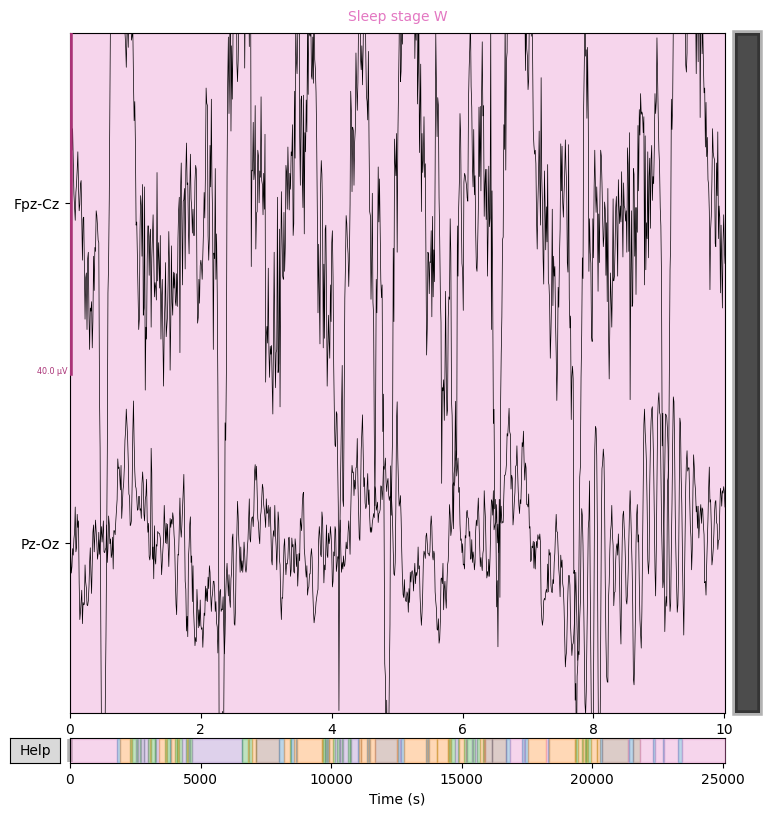

In [11]:
# Plot a recording as a sanity check
raws[0].plot();

## 2. Preprocessing raw data

Next, we need to preprocess the raw data. Here, we use a simple filtering step, followed by the extraction of 30-s windows. 

Sleep EEG data has most of its relevant information below 30 Hz. Therefore, to mitigate the impact of higher frequency noise, we apply a lowpass filter with cutoff frequency of 30 Hz to our recordings.

In [12]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place

/Users/hubertjb/miniconda3/envs/dl-eeg-tutorial/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


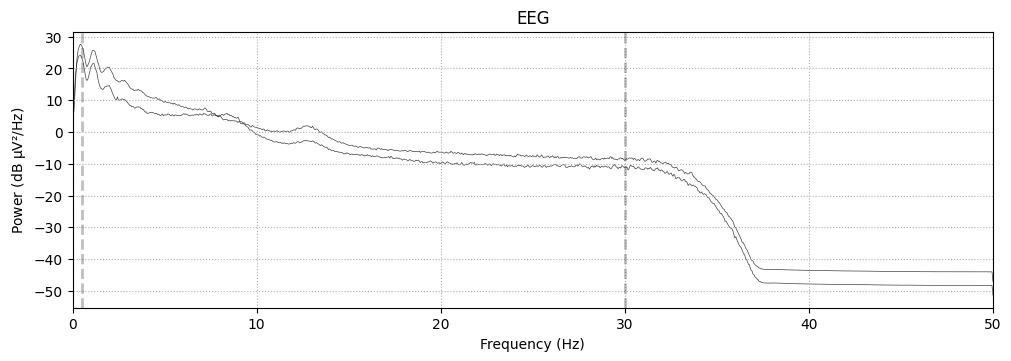

In [13]:
# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

From the power spectral density plot, we can see that our filter has indeed cut off most of the power above 30 Hz.

Before proceeding to extracting 30-s windows (also called *epochs*) from the filtered data, we define a few functions that we will need:

In [14]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [15]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

We can now extract windows from each recording, and wrap them into Pytorch datasets.

In [16]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], 
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale) 
                for raw in raws]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

You might have noticed we added a scaling transform to the datasets. This scaling makes sure each EEG channel in each 30-s window has a mean of 0 and a standard deviation of 1. This will help the neural network when training.

## 3. Making train, valid and test splits

Now that we have our preprocessed and windowed data, we can split it into the different sets that we will need: (1) the **training set** is used to learn the parameters of our ConvNet, (2) the **validation set** is used to monitor the training process and decide when to stop it, and (3) the **test set** is used to provide an estimate of the generalization performance of our model.

Here, we keep recording 1 of subjects 0-9 for testing, and split the remaining recordings into training and validation sets.

We define the following functions to perform the split:

In [17]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
                
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None
    
    return pick_ds, remaining_ds
    

def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [18]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

In [19]:
# Use recording 1 of subjects 0-9 as test set
test_recs = [(subj_nb, rec_nb)  # DO NOT CHANGE! This is a fixed set.
             for subj_nb, rec_nb in zip(range(10), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [20]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 18545
Validation: 4094
Test: 9850


Finally, we notice that the classes are imbalanced, i.e., there are a lot more of some classes than others. N2, especially, is more prevalent than the other sleep stages during the night:

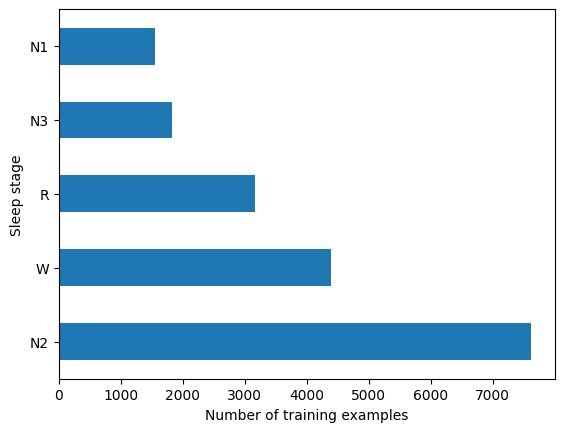

In [21]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

One way to account for this imbalance during training is to give more weight to examples from rarer classes when computing the loss. We compute the weights with the following:

In [22]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.84583808 2.37908916 0.48700105 2.03567508 1.17262093]


## 4. Creating the neural network

In this section, we will define our ConvNet architecture. 

By default, we use the sleep staging architecture of Chambon et al. (2018), which looks something like this (adapted from Banville et al. 2020):

![convnet](figs/convnet.png "SleepStagerChambon2018")

The **input**, on the left, is a 30-s window of `C` channels. By default we have set `C` to 2 by selecting the 2 available EEG channels in Sleep Physionet above.

The **output**, on the right, is a 5-dimensional vector where each dimension is matched to one of our 5 classes (W, N1, N2, N3 and R sleep stages).

In between, we have a succession of convolutional layers, max pooling, and nonlinearities. The feature maps are finally flattened and passed through a fully-connected layer.

We define the neural network in the following `torch.nn.Module` class:

In [23]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

We instantiate our ConvNet with the following:

In [24]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5)

Depending on whether a CUDA-enabled GPU is available, we can move the model to the GPU and perform the training there. This can enable significant speed-ups, but is not strictly required for this tutorial.

In [25]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


## 5. Train and monitor network

We are almost ready to finally train our ConvNet!

We first need to define `DataLoader`s. `DataLoader` is a pytorch object that wraps a dataset and makes it easy to obtain batches of examples to feed to our neural network.

In [26]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

Next, we define a few functions to carry out our training and validation loops:

In [27]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

Two critical pieces of the training process are the **optimizer** and the **criterion**.

* The **optimizer** implements the parameter update procedure. Here, we use `Adam`, a popular adaptive gradient descent optimizer for deep neural networks.
* The **criterion**, or loss function, is used to measure how well the neural network performs on an example. Here, we use the standard multiclass cross-entropy loss.

In [28]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

We can now launch our training loop. The maxmium number of training epochs (or "passes" through the training set) is set with `n_epochs`. The `patience` hyperparameter controls how many epochs we will wait for before stopping the training process if there is no improvement on the validation set.

In [29]:
n_epochs = 10
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.1059 	 0.9292 	 0.3556 	 0.4295
best val loss inf -> 0.9292
2 	 0.8101 	 0.8447 	 0.5546 	 0.5372
best val loss 0.9292 -> 0.8447
3 	 0.7426 	 0.7790 	 0.5992 	 0.5550
best val loss 0.8447 -> 0.7790
4 	 0.6986 	 0.8260 	 0.6336 	 0.5428
5 	 0.6797 	 0.7561 	 0.6439 	 0.5945
best val loss 0.7790 -> 0.7561
6 	 0.6517 	 0.7886 	 0.6597 	 0.5864
7 	 0.6489 	 0.7930 	 0.6637 	 0.5742
8 	 0.6373 	 0.7791 	 0.6727 	 0.5916
9 	 0.6271 	 0.7582 	 0.6719 	 0.5952
10 	 0.6218 	 0.8301 	 0.6796 	 0.5798
Stop training at epoch 10
Best val loss : 0.7561


Next, we visualize the results of our training.

First, the training curves show how the loss and accuracy improved across training epochs. We use [Cohen's kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-kappa) (instead of the standard accuracy) to better reflect performance under class imbalance and allow comparison with results from the literature.

Text(0, 0.5, "Cohen's kappa")

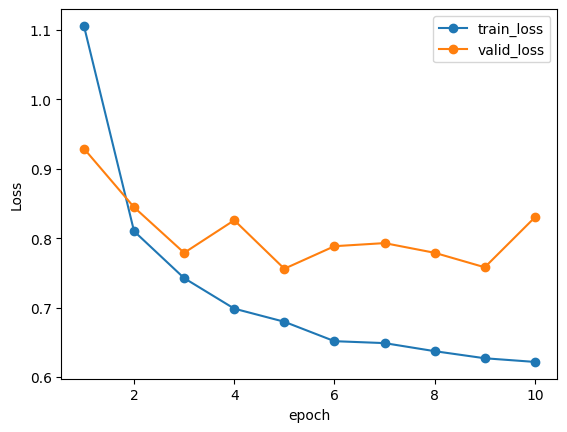

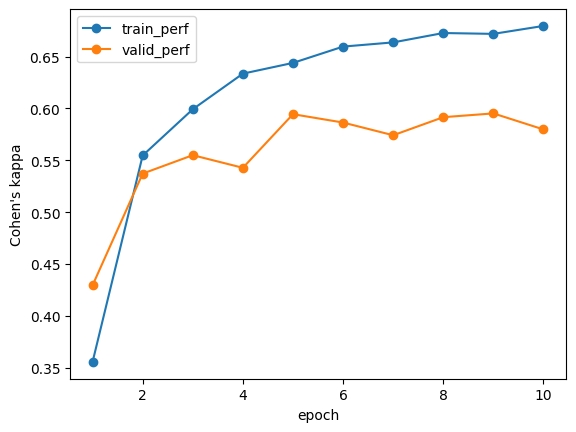

In [30]:
# Visualizing the learning curves

history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')

We expect the loss to decrease and the Cohen's kappa to increase as more and more training epochs are performed.

We also measure the performance on the test set, which was not seen during training. This gives us a better estimate of the generalization performance of our ConvNet.

In [31]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.761
Test Cohen's kappa: 0.693


For our 5-class problem, chance-level would correspond to 20% balanced accuracy or a Cohen's kappa of 0.0.

To get a sense of what is possible, a recent model achieved a kappa of 0.814 on the Sleep Physionet data using a single EEG channel (10-fold cross-validation):

> Phan, H., Chén, O. Y., Koch, P., Mertins, A., & De Vos, M. (2020). Xsleepnet: Multi-view sequential model for automatic sleep staging. arXiv preprint arXiv:2007.05492

## 6. Visualizing results

We further inspect the results in this section.

We start by looking at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), which shows which classes were easier or more difficult to classify for our ConvNet.

In [32]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()
    
    return fig, ax

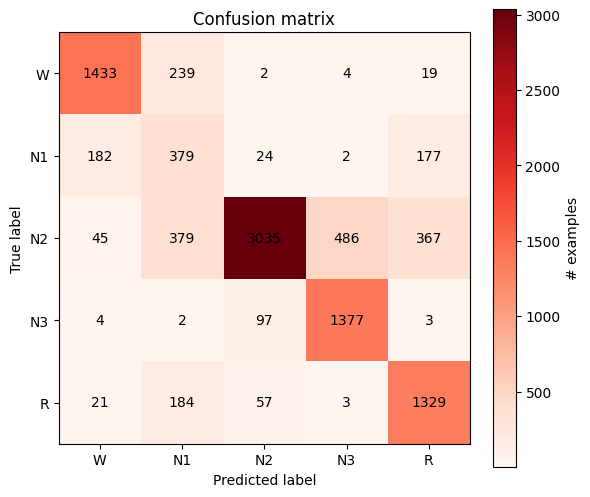

In [33]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

What kind of mistakes does the ConvNet seem to make? Is there a class that's often mistaken for another one?

We can also visualize the predictions on a recording basis. This visualization is known as a "[hypnogram](https://en.wikipedia.org/wiki/Hypnogram)". A hypnogram shows the evolution of sleep stages across an overnight recording.

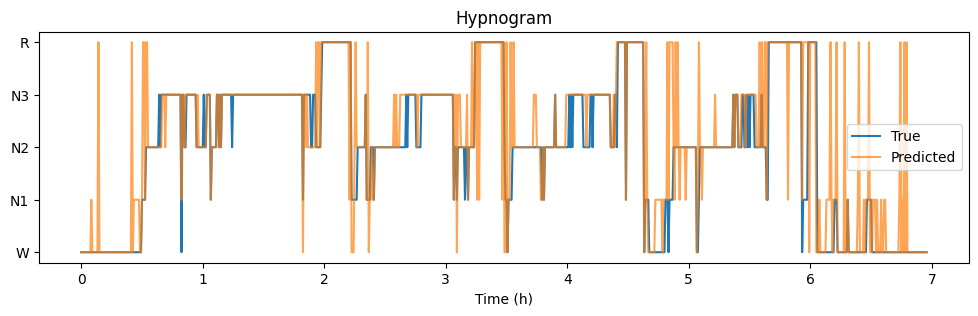

In [34]:
# Plot hypnogram for one recording

mask = rec_ids == 0  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend();

Do the predictions of the ConvNet follow the groundtruth hypnogram? Is there any structure in the way mistakes are made?

## Going further

You've now covered all the material for this tutorial!

To test what you have learned, we recommend you identify a few key elements in the pipeline shown above, and play with them to try to improve the performance of your ConvNet. Here are a few ideas to get you started:
- Increasing the training set size
- Improving the architecture (you can look at recent sleep staging literature, or follow your intuition!)
- Optimizing the training hyperparameters (learning rate, batch size, etc.)

Good luck! :)